# THE FUNDAMENTALS OF AUTOGRAD

PyTorch的Autograd功能是PyTorch在构建机器学习项目时灵活、快速的原因之一。它允许在一个复杂的计算中快速和便捷地计算多个偏导数（也被称为梯度）。这种操作是基于反向传播的神经网络学习的核心。

autograd的强大之处在于它在运行时动态追踪你的计算，这意味着如果你的模型有决策分支，或者在运行时才知道其长度的循环，计算仍然会被正确追踪，你会得到正确的梯度来驱动学习。这一点，再加上你的模型是用Python构建的，比那些依靠静态分析更严格的结构化模型来计算梯度的框架要灵活得多。

## What Do We Need Autograd For?

一个机器学习的模型就是一个带有输入和输出的函数。在这一节的讨论中，我们把带有$x_i$元素的一个i维向量 $\vec x$作为输入。然后，我们可以将模型M表示为输入的矢量值函数： $\vec y = \vec M (\vec x)$。（我们把M的输出值当作一个向量，因为一般来说，一个模型可以有任何数量的输出。）

由于我们主要是在训练的背景下讨论autograd，我们感兴趣的输出将是模型的损失。损失函数$L(\vec y) = L(\vec M(\vec x))$是一个模型输出的单值的标量函数。这个函数表示我们的模型预测与某一特定输入的理想输出有多大的偏差。注意：在这之后，我们通常会在上下文明确的省略矢量符号--例如，$y$代表$\vec y$。

在训练一个模型时，我们要使损失最小化。在理想化的完美模型的情况下，这意味着调整其学习权重--也就是函数的可调参数--使所有输入的损失为零。在现实世界中，这意味着一个反复调整学习权重的过程，直到我们看到模型在各种输入下都可以得到一个可容忍的损失。

我们如何确定在多大程度上和哪个方向上推动权重？我们想使损失*最小化*，这意味着使其相对于输入的第一次导数等于0： $\frac{\partial L}{\partial x} = 0$。

不过，回顾一下，损失不是直接来自输入，而是模型输出的一个函数（是输入的一个函数），$\frac {\partial L}{\partial x} = \frac {\partial L(\vec y)}{\partial x}$，根据链式求导法则，我们有$\frac {\partial L(\vec y)}{\partial x} = \frac {\partial L}{\partial y} \frac {\partial y}{\partial x} = \frac {\partial L}{\partial y} \frac {\partial M(x)}{\partial x}$。

$\frac {\partial M(x)}{\partial x}$ 是事情变复杂的地方。模型输出的偏导数与它的输入有关，如果我们再次使用链式法则扩展表达式，这将涉及到对每一个乘法学习权重、每一个激活函数和模型中每一个其他数学变换的许多局部偏导。每个这样的偏导的完整表达式是通过计算图的每个可能路径的局部梯度的乘积之和，这些路径的终点是我们试图计算其梯度的变量。

特别地，我们感兴趣的是学习权重的梯度，它们告诉我们每个权重向*什么方向改变*来使损失趋近于0。

由于局部导数（每一个都相对于模型计算图的一个单独路径）的数量将会随着神经网络的深度呈指数级增长，它们计算的复杂度也是如此。这就是autograd介入的地方，它会追踪每一个计算的历史。PyTorch模型中的每个计算张量都带有其输入张量和用于创建张量的函数的历史。再加上旨在作用于张量的PyTorch函数都有一个内置的实现来计算自己的导数，这大大加快了学习所需的局部导数的计算。

## A Simple Example

上面是一些理论，但是在实践中使用autograd是什么样的呢？

让我们通过一个简单的样例看看。首先，首先，我们要做一些导入，让我们把结果以图的形式展示出来：

In [2]:
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

接下来，我们将创建一个输入张量，该张量填充在区间 $[0,2\pi]$ 内均匀分布的数值，并指定 `requires_grad=True`。（和大多数创建张量的函数一样，`torch.linspace()` 接受一个可选的 `requires_grad` 选项）。设置这个标志意味着在接下来的每一次计算中，autograd将在该计算的输出张量中积累计算的历史。

In [3]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


接下来，我们将进行一次计算，并根据其输入绘制其输出：

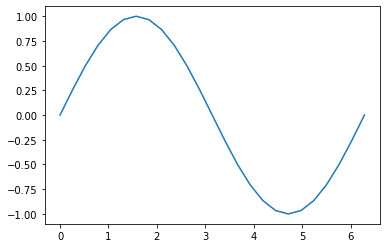

In [4]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

我们在仔细的看一下张量 `b`。当我们打印它，我们看到了一个指标，它正在跟踪其计算历史：

In [5]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


这个 `grad_fn` 给了我们一个提示，当我们执行反向传播步骤并计算梯度时，我们需要为这个张量的所有输入计算$\sin(x)$的梯度。

让我们再进行一些计算：

In [6]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


最后，让我们来计算一个单元素的输出。当你在一个没有参数的张量上调用 `.backward()` 时，它希望调用的张量只包含一个元素，就像计算损失函数时的情况。

In [7]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


与我们的张量一起存储的每个 `grad_fn` 允许你通过其 `next_functions` 属性将计算一直追溯到其输入。我们可以看到，在 `d` 的这个属性上往下追溯，可以看到所有先前的张量的梯度函数。请注意，`a.grad_fn` 被报告为 `None` ，表明这是一个没有历史的函数的输入。

In [8]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f80522805d0>, 0), (None, 0))
((<SinBackward0 object at 0x7f805222f290>, 0), (None, 0))
((<AccumulateGrad object at 0x7f80522805d0>, 0),)
()

c:

b:

a:
None


有了所有这些机制，我们如何获得导数呢？我们可以在输出上调用 `backward()` 方法，并检查输入的 `grad` 属性以检查梯度：

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


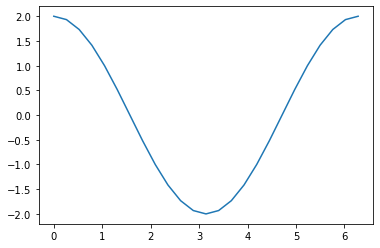

In [9]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

回忆一下我们走到这里的计算步骤：

In [10]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

添加一个常数，就像我们计算 `d` 那样，并不改变导数。这样，$c= 2 \times b=2 \times sin(a)$，其导数应该是 $2 \times cos(a)$。看一下上面的图，这就是我们看到的情况。

请注意，只有计算的叶子节点才会计算它们的梯度。如果你尝试 `print(c.grad)` 你会得到 `None`。在这个简单的例子中，只有输入是一个叶子节点，所以只有它有梯度计算。

## Autograd in Training

我们已经简单了解了autograd的工作原理，但当它被用于预定的目的时，它看起来如何？让我们定义一个小模型，并检查它在一个训练批次后的变化。首先，定义几个常量，我们的模型，以及一些输入和输出的替代：

In [18]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):
    
    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

你可能会注意到一件事，我们从未为模型的层指定 `requires_grad=True`。在 `torch.nn.Module` 的子类中，我们假定要跟踪各层权重的梯度进行学习。

如果我们看一下模型的层，我们可以检查权重的值，并验证是否还没有计算梯度：

In [19]:
print(model.layer2.weight[0][0:10]) # 一个小切片
print(model.layer2.weight.grad)

tensor([-0.0682,  0.0344,  0.0158,  0.0015,  0.0012,  0.0013,  0.0707, -0.0115,
        -0.0758, -0.0405], grad_fn=<SliceBackward0>)
None


让我们看看当我们运行一个训练批次时，情况会有什么变化。我们使用我们的预测和理想输出之间的欧氏距离的平方作为损失函数，并且我们将使用一个基本的随机梯度下降优化器。

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(131.5259, grad_fn=<SumBackward0>)


现在我们调用 `loss.backward()` 并且看看发生了什么：

In [21]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0682,  0.0344,  0.0158,  0.0015,  0.0012,  0.0013,  0.0707, -0.0115,
        -0.0758, -0.0405], grad_fn=<SliceBackward0>)
tensor([ 2.0845,  0.4690, -4.0173,  2.4279,  0.9756, -0.8618,  2.5182,  1.6739,
        -2.2831,  1.1891])


In [24]:
# model.layer2.weight[0][0:10] - model.layer2.weight.grad[0][0:10] * 1e-3

我们可以看到，每个学习权重的梯度已经计算出来了，但是权重仍然没有变化，因为我们还没有运行优化器。优化器负责根据计算的梯度更新模型权重。

In [23]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0703,  0.0339,  0.0198, -0.0009,  0.0002,  0.0021,  0.0682, -0.0131,
        -0.0735, -0.0417], grad_fn=<SliceBackward0>)
tensor([ 2.0845,  0.4690, -4.0173,  2.4279,  0.9756, -0.8618,  2.5182,  1.6739,
        -2.2831,  1.1891])


你应该看到了 `layer2` 的权重发生了变化。

关于这个过程，有一件很重要的事情： 在调用 `optimizer.step()` 之后，你需要调用`optimizer.zero_grad()`，否则每次运行loss.backward()时，学习权重上的梯度会累积起来：

In [25]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()
    
print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([ 2.0845,  0.4690, -4.0173,  2.4279,  0.9756, -0.8618,  2.5182,  1.6739,
        -2.2831,  1.1891])
tensor([  8.2327,   3.3867, -13.0232,   8.7149,   5.0187,  -6.6933,  -5.5305,
         10.1438,  -4.4911,   6.5221])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


在运行上述单元后，你应该看到在多次运行 `loss.backward()` 后，大多数梯度的量级会大很多。在运行下一个训练批次之前，如果没有将梯度归零，将导致梯度以这种方式爆炸，造成不正确和不可预测的学习结果。

## Turning Autograd Off and On

在有些情况下，你需要对是否启用autograd进行细粒度的控制。根据不同的情况，有多种方法可以做到这一点。

最简单的是直接改变张量上的 `requires_grad` 标志：

In [26]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


在上面的单元格中，我们看到 `b1` 有一个 `grad_fn` （即追踪的计算历史），这是我们所期望的，因为它是从一个打开了autograd的张量 `a` 派生的。当我们用 `a.requires_grad = False` 明确地关闭autograd时，计算历史就不再被追踪了，正如我们在计算 `b2` 后看到的。

如果你只需要暂时关闭autograd，一个更好的方法是使用 `torch.no_grad()`：

In [27]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


`torch.no_grad()` 也可以作为一个函数或方法修饰器使用：

In [28]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


有一个相应的上下文管理器，`torch.enable_grad()`，当它没有打开的时候，用于打开autograd。它也可以作为一个修饰器使用。

最后，你可能有一个需要梯度跟踪的张量，但你想要一个不执行梯度跟踪的副本。为此，我们有张量对象的 `detach()` 方法，它会创建一个从计算历史中分离出来的张量副本：

In [29]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.5365, 0.5231, 0.7058, 0.5468, 0.9089], requires_grad=True)
tensor([0.5365, 0.5231, 0.7058, 0.5468, 0.9089])


正如我们上面所做的，当我们想对一些张量进行绘图时。因为 `matplotlib` 希望一个NumPy数组作为输入，而对于 `requires_grad=True` 的张量来说，从PyTorch张量到NumPy数组的隐式转换并没有启用。使用一个分离的副本可以让我们的方法得以正确执行。

## Autograd and In-place Operations

到目前为止，在这个笔记本的每个例子中，我们都使用了变量来捕捉计算的中间值。Autograd需要这些中间值来进行梯度计算。出于这个原因，在使用autograd时，你必须谨慎使用原地操作。这样做会破坏你在 `backward()` 调用中计算导数所需的信息。如果你试图对需要autograd的叶子变量进行原地操作，PyTorch甚至会阻止你，如下所示。

> **小贴士**
>
> 下面的代码会抛出一个runtime error.这是意料之中的。

In [30]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
torch.sin_(a)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

## Autograd Profiler

Autograd详细地跟踪你的每一步计算。这样的计算历史，结合时间信息，将成为一个方便的剖析器--而autograd已经将这个功能内置于其中。下面是一个快速使用的例子：

In [32]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y

print(prf.key_averages().table(sort_by='self_cpu_time_total'))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    cudaGetDeviceProperties        64.96%       9.409ms        64.96%       9.409ms     940.900us       0.000us         0.00%       0.000us       0.000us            10  
                  aten::div        17.56%       2.543ms        17.56%       2.543ms       2.543us       6.881ms        41.53%       6.881ms       6.881us          1000  
                  aten::mul        17.23%       2.496ms        17.23%       2.496ms       2.496us       9.689ms        58.47%       9.689ms       9.6

剖析器还可以标记代码的单个子块，按输入张量形状划分数据，并将数据导出为Chrome追踪工具文件。有关API的全部细节，请参见[文档](https://pytorch.org/docs/stable/autograd.html#profiler)。

## Advanced Topic: More Autograd Detail and the High-Level API

如果你有一个具有n维输入和m维输出的函数，$\vec y = f(\vec x)$，完整的梯度是每一个输出相对于每一个输入的导数的矩阵，称为*雅各布（Jacbian）矩阵*：

$J=\left(\begin{array}{ccc}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x 1} & \cdots & \frac{\partial y_m}{\partial x n}
\end{array}\right)$

如果你有第二个函数，$l = g(\vec y)$，它接受m维的输入（即与上述输出相同的维度），并返回一个标量的输出，你可以将其相对于 $\vec y$ 的梯度表达为一个列向量，$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y 1} & \cdots & \frac{\partial l}{\partial y m}\end{array}\right)^T$ ，这实际上只是一个单列的雅各布式。

更具体地说，把第一个函数想象成你的PyTorch模型（可能有许多输入和许多输出），第二个函数是一个损失函数（模型的输出是输入，损失值是标量输出）。

如果我们将第一个函数的雅各布矩阵乘以第二个函数的梯度，并应用链式法则，我们得到：

$
J^T \cdot v=\left(\begin{array}{ccc}
\frac{\partial y 1}{\partial x 1} & \cdots & \frac{\partial y m}{\partial x 1} \\
\vdots & \ddots & \vdots \\
\frac{\partial y 1}{\partial x n} & \cdots & \frac{\partial y m}{\partial x n}
\end{array}\right)\left(\begin{array}{c}
\frac{\partial l}{\partial y 1} \\
\vdots \\
\frac{\partial l}{\partial y m}
\end{array}\right)=\left(\begin{array}{c}
\frac{\partial l}{\partial x 1} \\
\vdots \\
\frac{\partial l}{\partial x_n}
\end{array}\right)
$

注意：你也可以使用等价的操作$v^T\cdot J$，并得到一个行向量。

由此产生的列向量是第二个函数相对于第一个函数的输入的梯度，或者在我们的模型和损失函数的情况下，损失相对于模型输入的梯度。

**torch.autograd 是计算这些乘积的引擎。** 这就是我们如何在后向传播中积累学习权重的梯度。

由于这个原因，`backward()` 调用也可以接受一个可选的向量输入。这个向量代表了一组张量上的梯度，它被乘以前面的autograd追踪张量的雅各布矩阵。让我们用一个小的向量试一下具体的例子：

In [33]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ 536.0791, -592.8583, 1029.8279], grad_fn=<MulBackward0>)


如果我们现在试图调用 `y.backward()`，我们会得到一个运行时错误和一条信息，即梯度只能为标量输出隐式计算。对于一个多维输出，autograd 希望我们提供这三个输出的梯度，以便它能乘以雅各布矩阵：

In [34]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # 表示梯度
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


(请注意，输出梯度都与2的幂有关--这也是我们所期望的重复加倍操作）。

## The High-Level API

autograd上有一个API，让你直接访问重要的微分矩阵和向量操作。特别是，它允许你计算特定输入下的特定函数的Jacobian和Hessian矩阵。(Hessian与Jacobian相似，但表达了所有的部分二阶导数)。它还提供了与这些矩阵进行矢量乘积的方法。

让我们来看看一个简单函数的Jacobian，对2个单元素输入进行评估：

In [35]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # 函数的参数
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.5905]), tensor([0.7649]))


(tensor([[3.6096]]), tensor([[3.]]))

如果你仔细看，第一个输出应该等于$2e^x$（因为$e^x$的导数是$e^x$），第二个值应该为。

当然，你也可以用高阶张量来做这个：

In [36]:
inputs = (torch.rand(3), torch.rand(3)) # 函数的参数
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.1089, 0.5990, 0.4893]), tensor([0.5958, 0.6126, 0.7583]))


(tensor([[2.2300, 0.0000, 0.0000],
         [0.0000, 3.6405, 0.0000],
         [0.0000, 0.0000, 3.2624]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

`torch.autograd.functional.hessian()` 方法的工作原理与此相同（假设你的函数是可两二阶导的），但会返回一个所有二介导数的矩阵。

如果你提供了矢量，还有一个函数可以直接计算矢量-雅各比乘积：

In [37]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([-789.2786,  830.6387, -549.0214]),
 tensor([5.1200e+01, 5.1200e+02, 5.1200e-02]))

`torch.autograd.functional.jvp()` 方法执行与 `vjp()` 相同的矩阵乘法，操作数相反。`vhp()` 和 `hvp()` 方法对vector-Hessian积进行同样的操作。

欲了解更多信息，包括性能，请见[API文档](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)。